In [1]:
from TCSPC import *
plt.rcParams['figure.constrained_layout.use'] = True

In [2]:
NADH     = Phasor([0.75,0.25],[0.4,4])         #sim object
EGFP     = Phasor([0.497,0.503],[2.43,3.07])   #EGFP object
mCherry  = Phasor([0.83,0.17],[1.43,2.38]) #mCherry object
sim_list = [NADH,EGFP,mCherry]
sim_name = ['NADH','EGFP','mCherry']
for i in range(3):
    sim_list[i].name = sim_name[i] #add name attributes to objects

### Error bars

The data is rescaled such that the first data point $y_0$ is 1, i.e. $\tilde{y} = y/y_0$\
Error in rescaled data $\tilde{y}$:
$$\Delta \tilde{y} = \tilde{y} \cdot \sqrt{\left(\frac{\Delta y}{y}\right)^2+\left(\frac{\Delta y}{y_0}\right)^2}$$ 
where $\Delta y = \sqrt{y}$ as it is Poissonian noise.\
Hence $$\Delta \tilde{y} = \frac{y}{y_0}\sqrt{\frac{1}{y}+\frac{1}{y_0}}$$

In [3]:
EGFP.repeat_sim_results(method = 'leastsq')

In [95]:
result.components

[<lmfit.Model: Model(exp2)>]

In [98]:
x = ax[1].lines[0].get_xdata()

array([ 0.        ,  0.05277045,  0.1055409 ,  0.15831135,  0.21108179,
        0.26385224,  0.31662269,  0.36939314,  0.42216359,  0.47493404,
        0.52770449,  0.58047493,  0.63324538,  0.68601583,  0.73878628,
        0.79155673,  0.84432718,  0.89709763,  0.94986807,  1.00263852,
        1.05540897,  1.10817942,  1.16094987,  1.21372032,  1.26649077,
        1.31926121,  1.37203166,  1.42480211,  1.47757256,  1.53034301,
        1.58311346,  1.63588391,  1.68865435,  1.7414248 ,  1.79419525,
        1.8469657 ,  1.89973615,  1.9525066 ,  2.00527704,  2.05804749,
        2.11081794,  2.16358839,  2.21635884,  2.26912929,  2.32189974,
        2.37467018,  2.42744063,  2.48021108,  2.53298153,  2.58575198,
        2.63852243,  2.69129288,  2.74406332,  2.79683377,  2.84960422,
        2.90237467,  2.95514512,  3.00791557,  3.06068602,  3.11345646,
        3.16622691,  3.21899736,  3.27176781,  3.32453826,  3.37730871,
        3.43007916,  3.4828496 ,  3.53562005,  3.5883905 ,  3.64

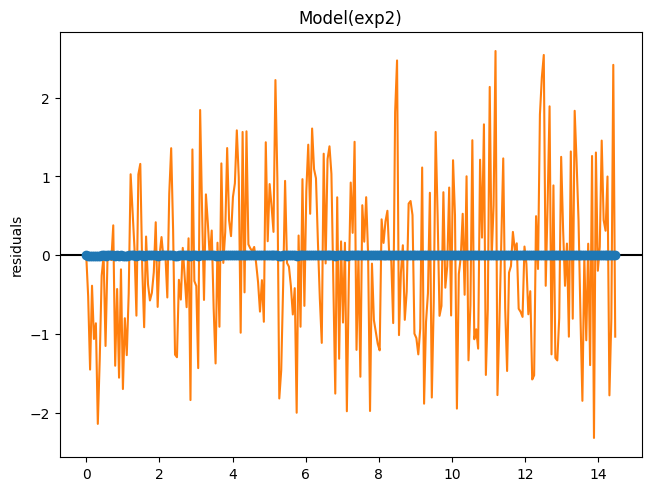

In [106]:
result.plot_residuals()
plt.plot(xdata,result.residual)

In [126]:
import matplotlib as mpl


result = EGFP.fit_results[0]

def plot_fit(result):
    '''Plot normalized residuals'''
    fig,ax = plt.subplots(nrows = 2, ncols =1,figsize = (6,6),gridspec_kw = {'height_ratios':[4,1]},sharex = True)
    result.plot_fit(ax=ax[0],datafmt = 'x',data_kws = {'alpha':0.7,'zorder':1})
    xdata = ax[0].lines[0].get_xdata() #xdata array for plotting residuals
    ax[1].set_ylabel('Normalized residuals')
    ax[1].plot(xdata,result.residual,'x')
    ax[1].axhline(0,c='k')
    ax[1].add_patch(mpl.patches.Rectangle((0,-1),xdata[-1],2,alpha = 0.3,color='g'))
    ax[1].set_yticks([-2,-1,0,1,2])
    for i in range(2):
        ax[i].set_xlim([0,xdata[-1]])
    ax[0].set_ylabel('Rescaled number of photons')
    ax[1].set_xlabel('Time/ns')
    ax[0].set_xlabel('')
    ax[0].set_yscale('log')
    return fig,ax

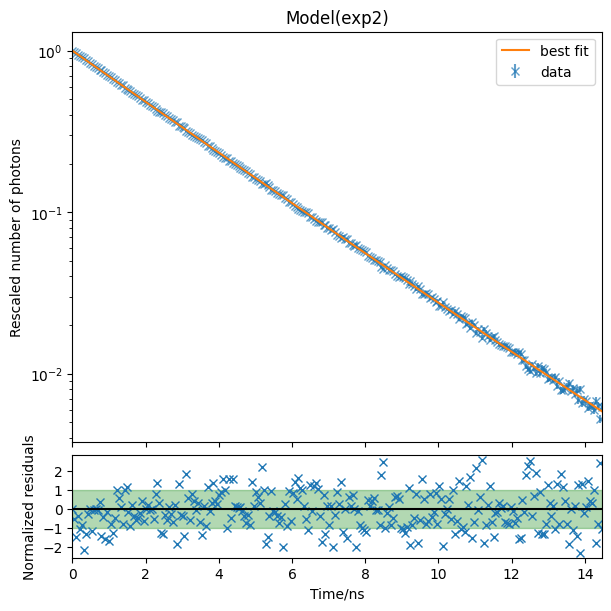

In [127]:
fig,ax = plot_fit(result)

In [21]:
fig.zorder

0

In [6]:
EGFP.repeat_sim_results(method = 'cobyla')

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lmfit/minimizer.py:847: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lmfit/minimizer.py:854: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lmfit/minimizer.py:847: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lmfit/minimizer.py:854: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lmfit/minimizer.py:847: RuntimeWarning: invalid value encountered in sqrt
  par.st

In [15]:
EGFP.par_df.loc[(slice(0,99),'stderr'),:]

,,A1,tau1,tau2
0,stderr,0.176769,0.099328,0.1047
1,stderr,0.220628,0.119922,0.129021
2,stderr,NaN,NaN,NaN
3,stderr,NaN,NaN,NaN
4,stderr,0.185976,0.128388,0.134787
...,...,...,...,...
95,stderr,NaN,NaN,NaN
96,stderr,0.208815,0.13196,0.138089
97,stderr,0.207824,0.148145,0.152524
98,stderr,NaN,NaN,NaN


In [23]:
EGFP.repeat_sim_results(method = 'leastsq')

In [24]:
EGFP.info_df

,chisqr,redchi,_val,init_value,stderr,correl
0,280.947199,1.032894,"[0.919, 2.67, 3.78]","[0.497, 2.43, 3.07]","[0.0979, 0.057, 0.706]","[{'tau1': '0.997', 'tau2': '0.999'}, {'A1': '0..."
1,253.122644,0.930598,"[0.946, 2.7, 4.03]","[0.497, 2.43, 3.07]","[0.0617, 0.0416, 0.814]","[{'tau1': '0.996', 'tau2': '0.998'}, {'A1': '0..."
2,264.147757,0.971131,"[0.42, 2.38, 3.02]","[0.497, 2.43, 3.07]","[0.265, 0.202, 0.151]","[{'tau1': '0.998', 'tau2': '0.999'}, {'A1': '0..."
3,203.062010,0.746552,"[0.84, 2.62, 3.47]","[0.497, 2.43, 3.07]","[0.15, 0.0746, 0.415]","[{'tau1': '0.998', 'tau2': '0.999'}, {'A1': '0..."
4,237.078369,0.871612,"[0.41, 2.32, 3.03]","[0.497, 2.43, 3.07]","[0.179, 0.155, 0.111]","[{'tau1': '0.998', 'tau2': '0.999'}, {'A1': '0..."
...,...,...,...,...,...,...
95,214.542762,0.788760,"[0.389, 2.39, 2.99]","[0.497, 2.43, 3.07]","[0.287, 0.222, 0.145]","[{'tau1': '0.999', 'tau2': '0.999'}, {'A1': '0..."
96,230.707731,0.848190,"[0.671, 2.52, 3.22]","[0.497, 2.43, 3.07]","[0.244, 0.124, 0.264]","[{'tau1': '0.998', 'tau2': '0.999'}, {'A1': '0..."
97,285.027512,1.047895,"[0.12, 1.76, 2.87]","[0.497, 2.43, 3.07]","[0.0337, 0.16, 0.0221]","[{'tau1': '0.988', 'tau2': '0.993'}, {'A1': '0..."
98,223.436582,0.821458,"[0.631, 2.52, 3.17]","[0.497, 2.43, 3.07]","[0.282, 0.144, 0.255]","[{'tau1': '0.999', 'tau2': '0.999'}, {'A1': '0..."
